# Write your first Qiskit Serverless program

Creating utility-scale quantum applications generally requires a variety of compute resource requirements. You can use Qiskit Serverless to easily submit quantum workflows for remote, managed execution on IBM Quantum&trade; Platform. These quantum workflows can typically be implemented within a common pattern, called a Qiskit pattern. A Qiskit pattern is an intuitive, repeatable set of steps for implementing a quantum computing workflow.

Steps in a Qiskit pattern:

1. Map classical inputs to a quantum problem
2. Optimize problem for quantum execution
3. Execute using Qiskit Runtime primitives
4. Post-process, return result in classical format

Once you have built a Qiskit pattern, you can use Qiskit Serverless to deploy and submit it for managed execution.

## Example: parallel transpilation with Qiskit Serverless

This example demonstrates how to create a parallel transpilation program and deploy it to IBM Quantum&trade; Platform to use as a reusable remote service.

### Set up the circuits

In [2]:
from qiskit.circuit.library import (
    NLocal,
    RXGate,
    RYGate,
    RZGate,
    HGate,
    CXGate,
    CZGate,
    SwapGate,
)
import random


# Function to generate a random rotation gate with a random angle
def random_rotation_gate():
    gate_class = random.choice([RXGate, RYGate, RZGate])
    theta = random.uniform(0, 2 * 3.14159)  # Random angle between 0 and 2π
    return gate_class(theta)


# Mapping for single-qubit gates
single_qubit_gates = [random_rotation_gate, HGate]

# Mapping for entangling gates
entangling_gates = [CXGate, CZGate, SwapGate]


# Function to generate a random NLocal circuit
def create_random_nlocal():
    num_layers = random.randint(1, 4)  # Randomly choose between 1 and 4 layers
    rotation_blocks = [
        random.choice(single_qubit_gates)() for _ in range(random.randint(1, 3))
    ]
    entanglement_block = random.choice(entangling_gates)()
    entanglement = random.choice(
        ["linear", "full"]
    )  # Randomly choose the entanglement pattern

    nlocal_circuit = NLocal(
        num_qubits=20,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=[entanglement_block],
        entanglement=entanglement,
        reps=num_layers,
    )
    return nlocal_circuit


# Generate 30 random NLocal circuits
nlocal_circuits = [create_random_nlocal() for _ in range(30)]

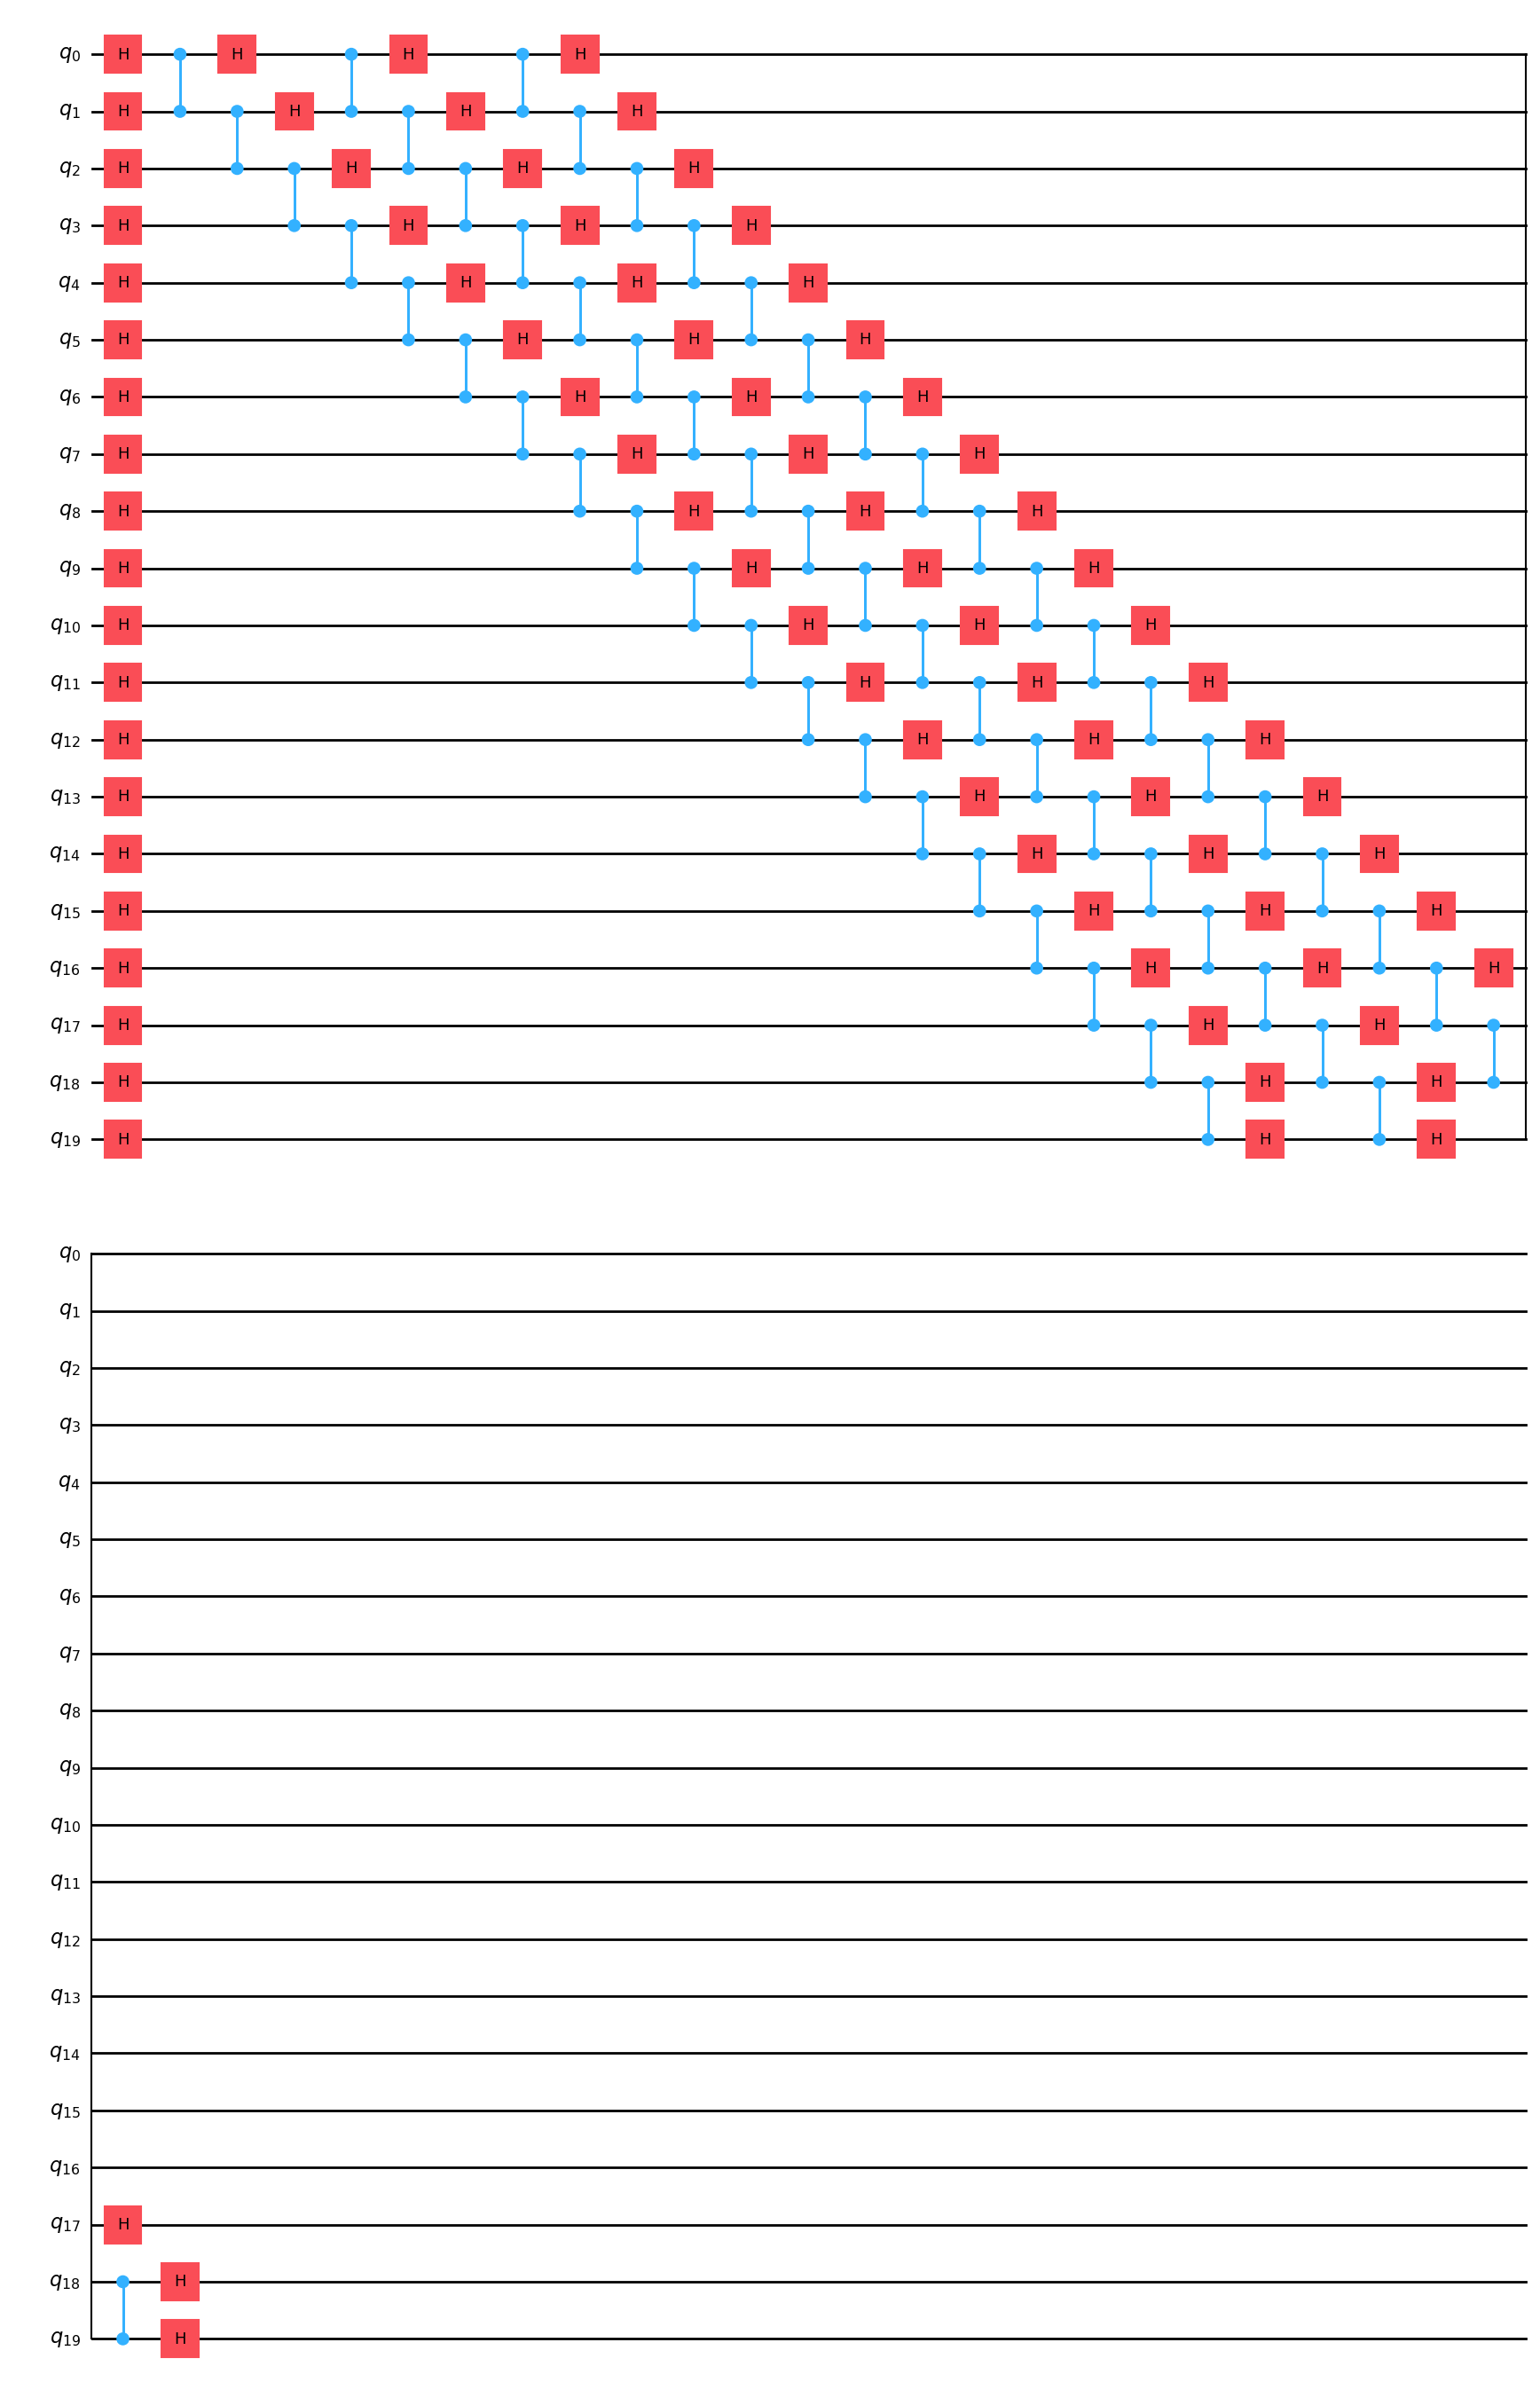

In [3]:
nlocal_circuits[0].decompose().draw()

### Choose a backend

Your abstract circuits will be optimized to run on this backend.

In [6]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

### Set up your local program

Use this local version as a benchmark. Set up your backend and basic transpilation options as follows.

In [7]:
# Local tranpsilation

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def transpile_parallel_local(circuit: QuantumCircuit, backend):
    """Transpiles an abstract circuit into an ISA circuit for a given backend."""
    pass_manager = generate_preset_pass_manager(
        optimization_level=3, backend=backend
    )
    isa_circuit = pass_manager.run(circuit)
    return isa_circuit

### Run the local version

In [ ]:
transpile_parallel_local(nlocal_circuits[0], backend)

In [9]:
from timeit import default_timer as timer
import warnings

warnings.filterwarnings("ignore")

start = timer()

# run distributed tasks as async function
# we get task references as a return type
tranpsiled_circuits = [
    transpile_parallel_local(circuit, backend)
    for circuit in nlocal_circuits
]

end = timer()
print(end - start)

683.1403828749899


### Deploy to IBM Quantum Platform

Authenticate to the `IBMServerlessClient` with your IBM Quantum token, which you can find in your [IBM Quantum account](https://quantum.ibm.com/account), and upload the script.

In [10]:
from qiskit_serverless import IBMServerlessProvider, QiskitFunction

# Authenticate to the remote cluster and submit the pattern for remote execution
serverless = IBMServerlessProvider(
    token=API_TOKEN
)

In [15]:
transpile_parallel_demo = QiskitFunction(
    title="transpile_parallel",
    entrypoint="transpile_parallel.py",
    working_dir="./source/",
)

In [32]:
serverless.upload(transpile_parallel_demo)

'demo/transpile_parallel'

### Run in serverless environment

In [ ]:
serverless.list()

In [34]:
functions = {f.title: f for f in serverless.list()}
transpile_parallel_serverless = functions.get("demo/transpile_parallel")

In [35]:
job = transpile_parallel_serverless.run(circuits=nlocal_circuits, backend_name=backend.name)

In [66]:
job.status()

'DONE'

In [67]:
logs = job.logs()

for log in logs.splitlines():
    print(log)

Starting timer
2024-05-22 20:44:25,433	INFO worker.py:1405 -- Using address 172.17.39.93:6379 set in the environment variable RAY_ADDRESS
2024-05-22 20:44:25,433	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 172.17.39.93:6379...
2024-05-22 20:44:25,483	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at 172.17.39.93:8265 
231.3323629554361


In [68]:
result = job.result()

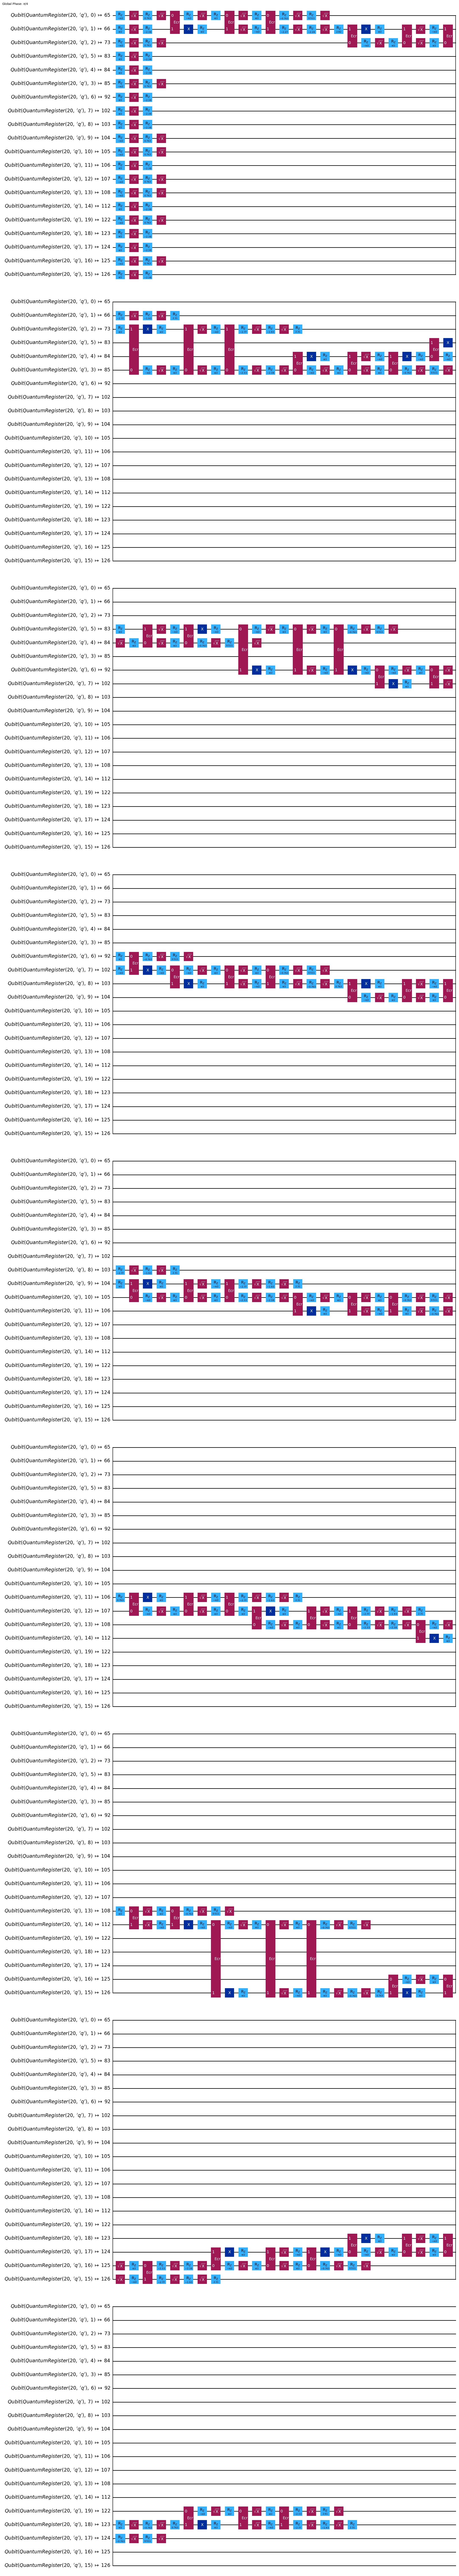

In [82]:
circuit = result['transpiled_circuits'][0]
circuit.draw(output='mpl', idle_wires=False)

## Add custom dependencies

This example uses the `pendulum` package as the custom dependency, and will calculate the difference in hours between Toronto and Vancouver timezones.

The following imports your custom dependency, `pendulum`, and uses its `datetime` method to calculate date times.

In [ ]:
# source_files/pattern_with_dependencies.py

# source_files/program_4.py

from qiskit_serverless import save_result

import pendulum

dt_toronto = pendulum.datetime(2012, 1, 1, tz='America/Toronto')
dt_vancouver = pendulum.datetime(2012, 1, 1, tz='America/Vancouver')

diff = dt_vancouver.diff(dt_toronto).in_hours()

print(diff)
save_result({"hours": diff})

Next, create and configure the client. 

To install a custom dependency that your pattern might use, pass it as the `dependencies` argument to the `QiskitFunctions` class constructor. You can pass multiple dependencies and specify versions.

In [ ]:
from qiskit_serverless import QiskitFunction

function = QiskitFunction(
    title="pattern-with-dependencies",
    entrypoint="pattern_with_dependencies.py",
    working_dir="./source_files/",
    dependencies=["pendulum==3.0.0"],
)

<Admonition type="warning">
This provider is set up with default credentials to a test cluster intended to run on your machine.
</Admonition>

In [ ]:
from qiskit_serverless import ServerlessClient
import os

client = ServerlessClient(
    token=os.environ.get("GATEWAY_TOKEN", "awesome_token"),
    host=os.environ.get("GATEWAY_HOST", "http://localhost:8000"),
)
client

<gateway-client>

In [ ]:
client.upload(function)
my_pattern_function = client.get("pattern-with-dependencies")
my_pattern_function

QiskitFunction(pattern-with-dependencies)

In [ ]:
job = my_pattern_function.run()
job

<Job | 5c579361-13e6-4d7c-9fc3-98e0b57ae232>

In [ ]:
job.status()

'QUEUED'

In [ ]:
job.result()

{'quasi_dists': {'0': 1.0}}

## Pass input arguments

Rather than define the circuit inside the pattern, here you can pass it as an argument, and save the results. You can then access them later by calling `save_result`.

In [ ]:
# source_files/pattern_with_arguments.py

from qiskit_serverless import get_arguments, save_result

from qiskit.primitives import Sampler

# get all arguments passed to this pattern
arguments = get_arguments()

# get specific argument that we are interested in
circuit = arguments.get("circuit")

sampler = Sampler()

quasi_dists = sampler.run(circuit).result().quasi_dists

print(f"Quasi distribution: {quasi_dists[0]}")

# saving results of a pattern
save_result({
    "quasi_dists": quasi_dists[0]
})

Create a circuit that you want to pass as an argument to the pattern.

In [ ]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw()